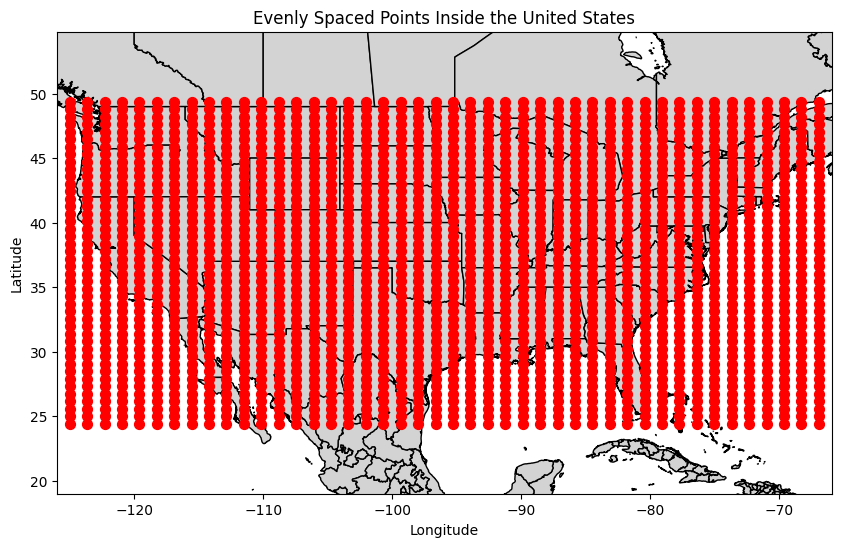

In [9]:
#!/usr/bin/env python3
# Grab as much data as I possbily can, using limiters of know api grab limits, execute later as nohup python file
import os
import sys
import time
import joblib  # Import joblib for saving and loading models
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from glob import glob
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool
from PIL import Image
from scipy.interpolate import griddata
import openmeteo_requests
import requests_cache
from retry_requests import retry
from dataclasses import dataclass
from timezonefinder import TimezoneFinder
import pytz



# Location to save data files
data_loc = '/work/bkelley/large_data/weather/'

# Wapi class definition as before

class Wapi:
    def __init__(self, cache_location=".cache", expire_after=-1, retries=5, backoff_factor=0.2):
        # Set up session with cache and retry mechanism
        self.cache_session = requests_cache.CachedSession(cache_location, expire_after=expire_after)
        self.retry_session = retry(self.cache_session, retries=retries, backoff_factor=backoff_factor)
        self.openmeteo = openmeteo_requests.Client(session=self.retry_session)

    @dataclass
    class Responses:
        hourly_response: pd.DataFrame = None

    @staticmethod
    def get_timezone(lat, lon):
        # Get timezone information
        lat, lon = float(lat), float(lon)
        tf = TimezoneFinder()
        timezone_str = tf.timezone_at(lat=lat, lng=lon)
        if timezone_str is None:
            return "Timezone not found"
        timezone = pytz.timezone(timezone_str)
        current_time = datetime.now(timezone)
        timezone_abbr = current_time.strftime('%Z')
        return f"Timezone: {timezone_str}, Abbreviation: {timezone_abbr}"

    def get_hist_data(self, lat, lon):
        start_date = "2022-01-01"
        end_date = (datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d')

        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation",
                       "rain", "weather_code", "surface_pressure", "cloud_cover",
                       "wind_speed_10m", "wind_speed_100m", "wind_direction_10m",
                       "wind_direction_100m"]
        }
        responses = self.openmeteo.weather_api(url, params=params)

        response = responses[0]
        print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
        print(Wapi.get_timezone(lat, lon))

        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ),
            "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
            "relative_humidity_2m": hourly.Variables(1).ValuesAsNumpy(),
            "precipitation": hourly.Variables(2).ValuesAsNumpy(),
            "rain": hourly.Variables(3).ValuesAsNumpy(),
            "weather_code": hourly.Variables(4).ValuesAsNumpy(),
            "surface_pressure": hourly.Variables(5).ValuesAsNumpy(),
            "cloud_cover": hourly.Variables(6).ValuesAsNumpy(),
            "wind_speed_10m": hourly.Variables(7).ValuesAsNumpy(),
            "wind_speed_100m": hourly.Variables(8).ValuesAsNumpy(),
            "wind_direction_10m": hourly.Variables(9).ValuesAsNumpy(),
            "wind_direction_100m": hourly.Variables(10).ValuesAsNumpy(),
        }
        hourly_dataframe = pd.DataFrame(data=hourly_data)

        return self.Responses(hourly_response=hourly_dataframe)


def grab_data(points_gdf, user_ID, overwrite=False):
    wapi_instance = Wapi()
    request_count = 0  # Requests in the current minute
    hourly_count = 0  # Requests in the current hour
    daily_count = 0  # Requests in the current day
    
    start_time = time.time()
    hour_start_time = time.time()  # Track start time for hourly limits
    day_start_time = time.time()  # Track start time for daily limits
    
    # Limits
    minute_limit = 500
    hour_limit = 5000
    day_limit = 10000

    for index, row in points_gdf.iterrows():
        lat, lon = row['geometry'].y, row['geometry'].x

        # Check if 60 seconds have passed and reset the counter for minute limit
        elapsed_time = time.time() - start_time
        if elapsed_time >= 60:
            request_count = 0
            start_time = time.time()

        # Handle rate limit for the minute
        if request_count >= minute_limit:
            time_to_wait = 60 - elapsed_time
            print(f"Approaching minute limit: waiting for {time_to_wait:.2f} seconds.")
            time.sleep(time_to_wait)  # Wait for remaining time in the minute
            request_count = 0
            start_time = time.time()

        # Handle rate limit for the hour
        hour_elapsed_time = time.time() - hour_start_time
        if hour_elapsed_time >= 3600:
            hourly_count = 0
            hour_start_time = time.time()

        if hourly_count >= hour_limit:
            hour_time_to_wait = 3600 - hour_elapsed_time
            print(f"Approaching hourly limit: waiting for {hour_time_to_wait:.2f} seconds.")
            time.sleep(hour_time_to_wait)
            hourly_count = 0
            hour_start_time = time.time()

        # Handle rate limit for the day
        day_elapsed_time = time.time() - day_start_time
        if day_elapsed_time >= 86400:
            daily_count = 0
            day_start_time = time.time()

        if daily_count >= day_limit:
            day_time_to_wait = 86400 - day_elapsed_time
            print(f"Approaching daily limit: waiting for {day_time_to_wait:.2f} seconds.")
            time.sleep(day_time_to_wait)
            daily_count = 0
            day_start_time = time.time()

        # Prepare the file path
        hourly_file = f"{data_loc}{user_ID}_{lat}_{lon}_hourly.csv"

        # Check if the file exists and whether to overwrite
        if not overwrite and os.path.exists(hourly_file):
            print(f"File already exists for ({lat}, {lon}). Skipping...")
            continue  # Skip to the next point

        try:
            # Fetch the data from the API
            data = wapi_instance.get_hist_data(lat, lon)
            
            # Save the data if the file doesn't exist or we want to overwrite
            data.hourly_response.to_csv(hourly_file, index=False)
            print(f"Data saved for {user_ID} at ({lat}, {lon})")

            # Update request count and other limits
            request_count += 1
            hourly_count += 1
            daily_count += 1

        except Exception as e:
            error_message = str(e)
            print(f"API request error: {error_message}")
            if "Minutely API request limit exceeded" in error_message:
                print("Minutely rate limit exceeded, waiting for 60 seconds before retrying.")
                time.sleep(60)
                request_count = 0
                start_time = time.time()
                continue  # Retry the same request

            # Add error message for hourly limit
            elif "Hourly API request limit exceeded" in error_message:
                print("Hourly rate limit exceeded, waiting for the next hour to retry.")
                # Calculate time to wait for the next hour
                hour_time_to_wait = 3600 - (time.time() - hour_start_time)
                print(f"Waiting for {hour_time_to_wait:.2f} seconds.")
                time.sleep(hour_time_to_wait)
                hourly_count = 0
                hour_start_time = time.time()
                continue  # Retry the same request

            # Add error message for daily limit
            elif "Daily API request limit exceeded" in error_message:
                print("Daily rate limit exceeded, waiting for the next day to retry.")
                # Calculate time to wait for the next day
                day_time_to_wait = 86400 - (time.time() - day_start_time)
                print(f"Waiting for {day_time_to_wait:.2f} seconds.")
                time.sleep(day_time_to_wait)
                daily_count = 0
                day_start_time = time.time()
                continue  # Retry the same request

        time.sleep(0.6)  # Adjust to avoid hitting rate limits, if necessary


def grab_evenly_spaced_us_points(n_points=2_000):
    # Southwest corner (min latitude, min longitude)
    min_lat = 24.396308
    min_lon = -125.0
    # Northeast corner (max latitude, max longitude)
    max_lat = 49.384358
    max_lon = -66.93457
    # Create evenly spaced latitudes and longitudes
    latitudes = np.linspace(min_lat, max_lat, int(np.sqrt(n_points)))
    longitudes = np.linspace(min_lon, max_lon, int(np.sqrt(n_points)))
    # Generate the grid of points (lat, lon)
    points = []
    for lat in latitudes:
        for lon in longitudes:
            points.append((lat, lon))
    # Convert points to GeoDataFrame
    geometry = [Point(lon, lat) for lat, lon in points]  # Point expects (x, y) = (lon, lat)
    points_gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")  # WGS84 coordinate system
    # Load the world map (No filtering by 'NAME' for United States)
    world = gpd.read_file('/work/bkelley/large_data/geospatial/data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
    # Plot the map
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot world boundary
    # Plot points
    points_gdf.plot(ax=ax, color='red', marker='o', markersize=50)
    # Set the axis limits to the bounding box of the United States
    ax.set_xlim(min_lon-1, max_lon+1)
    ax.set_ylim(min_lat-1, max_lat+1)
    # Set equal aspect ratio to avoid distortion
    ax.set_aspect('equal', adjustable='datalim')
    plt.title('Evenly Spaced Points Inside the United States')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    '''
    return points_gdf


def grab_data_for_training(latlon_list, user_ID):
    # Directory to save CSVs
    data_loc = '/work/bkelley/large_data/weather/data'
    # Extract lat, lon from GeoDataFrame points_gdf
    # Run the data grabbing function for each lat/lon point
    grab_data(latlon_list, user_ID)
    # Ensure the data is saved with the lat/lon as the filename
    for lat, lon in latlon_list:
        # Ensure the filename is unique and uses lat lon as filename
        lat_lon_filename = f"{data_loc}{user_ID}_{lat}_{lon}_hourly.csv"
        # Check if the CSV is generated and save the data
        if os.path.exists(lat_lon_filename):
            print(f"Data successfully saved for coordinates ({lat}, {lon}) at {lat_lon_filename}")
        else:
            print(f"Failed to save data for coordinates ({lat}, {lon})")
    return 0



if __name__ == "__main__":
    points_gdf = grab_evenly_spaced_us_points()
    grab_data_for_training(points_gdf, 123)